## 0. Import Libraries/Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration
### 1-1. Sample Images

In [2]:
root_dir = os.path.join(os.getcwd(), 'images')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

These are the facial expressions we're trying to detect

In [4]:
target_var = os.listdir(train_dir)
target_var

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

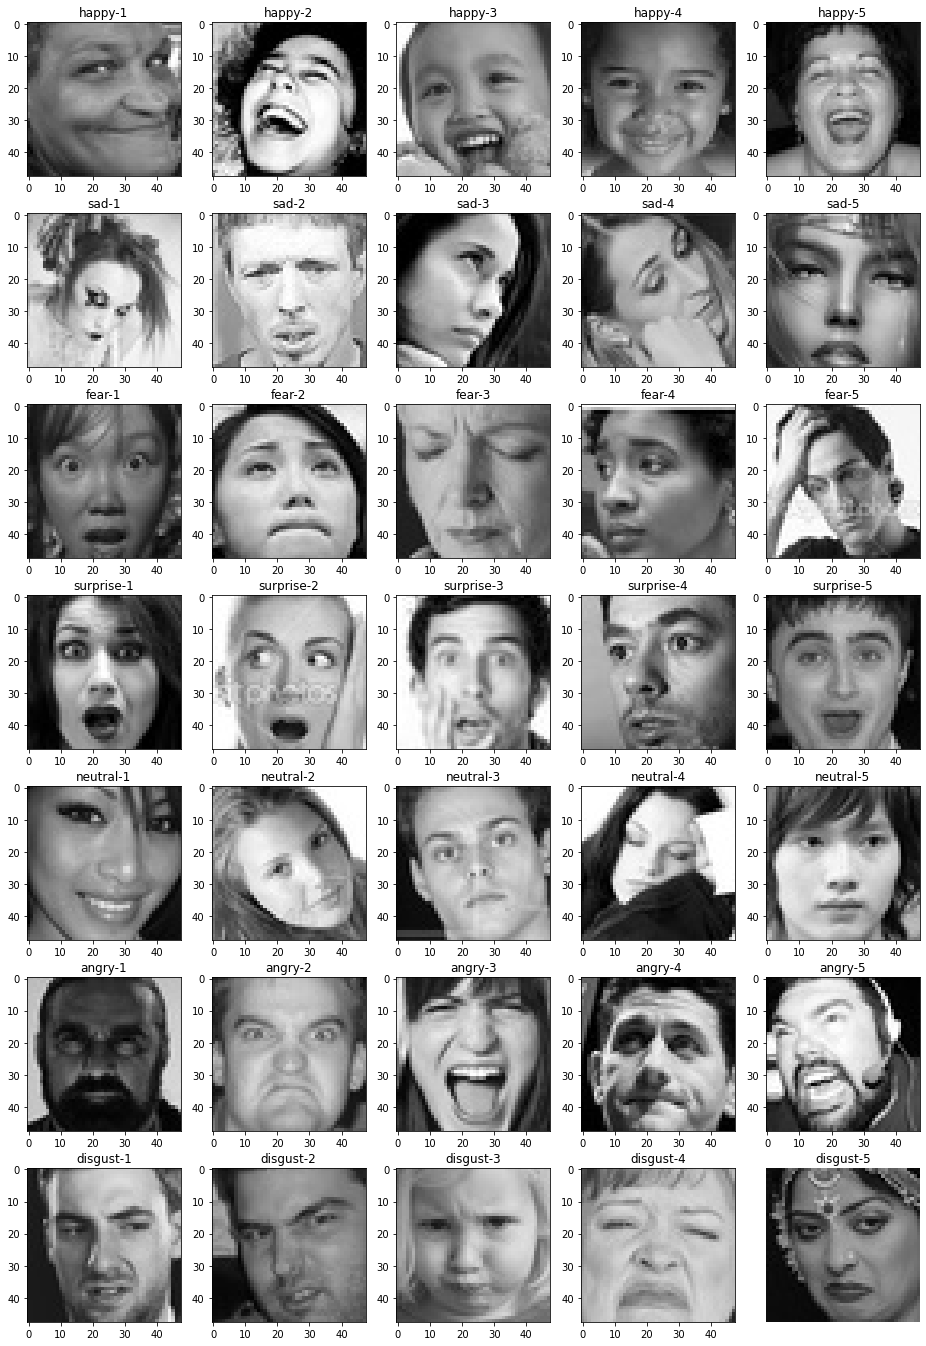

In [10]:
fig, axes = plt.subplots(7, 5, figsize=(16, 24))

for i in range(len(target_var)):
    for j in range(5):
        
        image = cv2.imread(os.path.join(train_dir, target_var[i], os.listdir(os.path.join(train_dir, target_var[i]))[j]))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        axes[i][j].imshow(image)
        axes[i][j].set_title(target_var[i] + "-" + str(j+1))
            
            
plt.axis('off')
plt.show()
        

### 1-2. Number of Images in Each Category

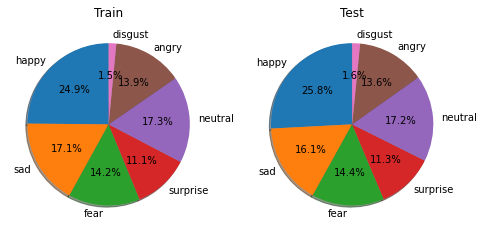

Emotion : happy
	Training : 7164
	 Testing : 1825
Emotion : sad
	Training : 4938
	 Testing : 1139
Emotion : fear
	Training : 4103
	 Testing : 1018
Emotion : surprise
	Training : 3205
	 Testing : 797
Emotion : neutral
	Training : 4982
	 Testing : 1216
Emotion : angry
	Training : 3994
	 Testing : 960
Emotion : disgust
	Training : 436
	 Testing : 111


In [14]:
x_train = np.array([ len(os.listdir(os.path.join(train_dir, i))) for i in target_var ])
x_test = np.array([ len(os.listdir(os.path.join(test_dir, i))) for i in target_var ])
label = target_var
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(os.path.join(train_dir, i)))) +'\n\t Testing : ' + str(len(os.listdir(os.path.join(test_dir, i)))))